In an earlier [post](), I explained how to apply a Bayesian linear regression model to retrievI use the historically accurate dataset behind the development of NASA OBPG's chlorophyll algorithms.

In [31]:
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.linear_model import LinearRegression
import re
import os
import numpy as np
import seaborn as sb
from mpl_toolkits.basemap import Basemap
import pymc3 as pm
import warnings
from cmocean import cm
warnings.filterwarnings('ignore')

In [2]:
% matplotlib inline

In [19]:
def ParseTextFile(textFileHandle, topickle=False, convert2DateTime=False, **kwargs):
    """
    * topickle: pickle resulting DataFrame if True
    * convert2DateTime: join date/time columns and convert entries to datetime objects
    * kwargs:
        pkl_fname: pickle file name to save DataFrame by, if topickle=True
    """
    # Pre-compute some regex
    columns = re.compile('^/fields=(.+)') # to get field/column names
    units = re.compile('^/units=(.+)') # to get units -- optional
    endHeader = re.compile('^/end_header') # to know when to start storing data
    # Set some milestones
    noFields = True
    getData = False
    # loop through the text data
    for line in textFileHandle:
        if noFields:
            fieldStr = columns.findall(line)
            if len(fieldStr)>0:
                noFields = False
                fieldList = fieldStr[0].split(',')
                dataDict = dict.fromkeys(fieldList)
                continue # nothing left to do with this line, keep looping
        if not getData:
            if endHeader.match(line):
                # end of header reached, start acquiring data
                getData = True 
        else:
            dataList = line.split(',')
            for field,datum in zip(fieldList, dataList):
                if not dataDict[field]:
                    dataDict[field] = []
                dataDict[field].append(datum)
    df = pd.DataFrame(dataDict, columns=fieldList)
    if convert2DateTime:
        datetimelabels=['year', 'month', 'day', 'hour', 'minute', 'second']
        df['Datetime']= pd.to_datetime(df[datetimelabels],
                                       format='%Y-%m-%dT%H:%M:%S')
        df.drop(datetimelabels, axis=1, inplace=True)
    if topickle:
        fname=kwargs.pop('pkl_fname', 'dfNomad2.pkl')
        df.to_pickle(fname)
    return df

def FindNaNs(df):
    for col in df.columns:
        sn = np.where(df[col].values=='NaN', True, False).sum()
        s9 = np.where('-999' in df[col].values, True, False).sum()
        print("%s: %d NaNs & %d -999s" % (col, sn, s9))
        
def FitPoly(X,y, order=4, lin=False):
    """
    Numpy regression. Returns coeffs.
    kwargs:
        lin: specifies whether data is log transformed. Data is log transformed if not."""
    if lin:
        X = np.log10(X)
        y = np.log10(y)
    coeffs = np.polyfit(X,y,deg=order)
    return coeffs

In [4]:
with open('/accounts/ekarakoy/DATA/ocprep_v4_iop.txt') as fdata:
    df = ParseTextFile(fdata, topickle=True, convert2DateTime=True,
                       pkl_fname=os.path.join(savDir, 'JeremyOCx_data'))

In [ ]:
df.info() # skipping output which shows a lot of unnecessary features for this exercise

Select features I want for this modeling bit.

In [6]:
basicCols = ['cruise', 'lat', 'lon', 'type', 'chl', 'Datetime']
IwantCols = basicCols + [col for col in df.columns if 'rrs' in col]
dfRrs = df[IwantCols]
swflbls = ['rrs411','rrs443','rrs489','rrs510','rrs555','rrs670']
swfCols = basicCols + swflbls
dfSwf = dfRrs[swfCols]

In [9]:
savDir = '/accounts/ekarakoy/DEV-ALL/BLOGS/DataScienceCorner/posts/bayesianChl_stuff/'
df.to_pickle(os.path.join(savDir, 'dfOcPrepHistoric.pkl'))
dfRrs.to_pickle(os.path.join(savDir, 'dfOcPrepRrs.pkl'))
del df, dfRrs

In [ ]:
dfSwf.info() # skipping the output which shows that most columns are object type...

In [12]:
FindNaNs(dfSwf)

cruise: 0 NaNs & 0 -999s
lat: 0 NaNs & 0 -999s
lon: 0 NaNs & 0 -999s
type: 0 NaNs & 0 -999s
chl: 535 NaNs & 0 -999s
Datetime: 0 NaNs & 0 -999s
rrs411: 22 NaNs & 0 -999s
rrs443: 0 NaNs & 0 -999s
rrs489: 0 NaNs & 0 -999s
rrs510: 0 NaNs & 0 -999s
rrs555: 0 NaNs & 0 -999s
rrs670: 0 NaNs & 0 -999s


In [14]:
dfSwf.replace(to_replace='NaN',value=np.NaN,inplace=True)
dfSwf.dropna(inplace=True)
numCols = ['chl','lat','lon','rrs411','rrs443','rrs489','rrs510','rrs555','rrs670']
dfSwf[numCols] = dfSwf[numCols].apply(pd.to_numeric)
dfSwf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1931 entries, 0 to 2482
Data columns (total 12 columns):
cruise      1931 non-null object
lat         1931 non-null float64
lon         1931 non-null float64
type        1931 non-null object
chl         1931 non-null float64
Datetime    1931 non-null datetime64[ns]
rrs411      1931 non-null float64
rrs443      1931 non-null float64
rrs489      1931 non-null float64
rrs510      1931 non-null float64
rrs555      1931 non-null float64
rrs670      1931 non-null float64
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 196.1+ KB


In [26]:
dfSwf['maxBlue'] = dfSwf[['rrs443', 'rrs489', 'rrs510']].max(axis=1)

In [27]:
dfSwf['OCxRatio'] = dfSwf.maxBlue/dfSwf.rrs555

In [29]:
dfLogOCx = pd.DataFrame(columns = ['OCxRatio','chl','type','cruise'])
dfLogOCx.OCxRatio = np.log10(dfSwf.OCxRatio)
dfLogOCx.chl = np.log10(dfSwf.chl)
dfLogOCx[['type','cruise']] = dfSwf[['type','cruise']]

In [34]:
dfSwf.to_pickle(os.path.join(savDir, 'dfSwf'))
dfLogOCx.to_pickle(os.path.join(savDir, 'dfLogOCx'))

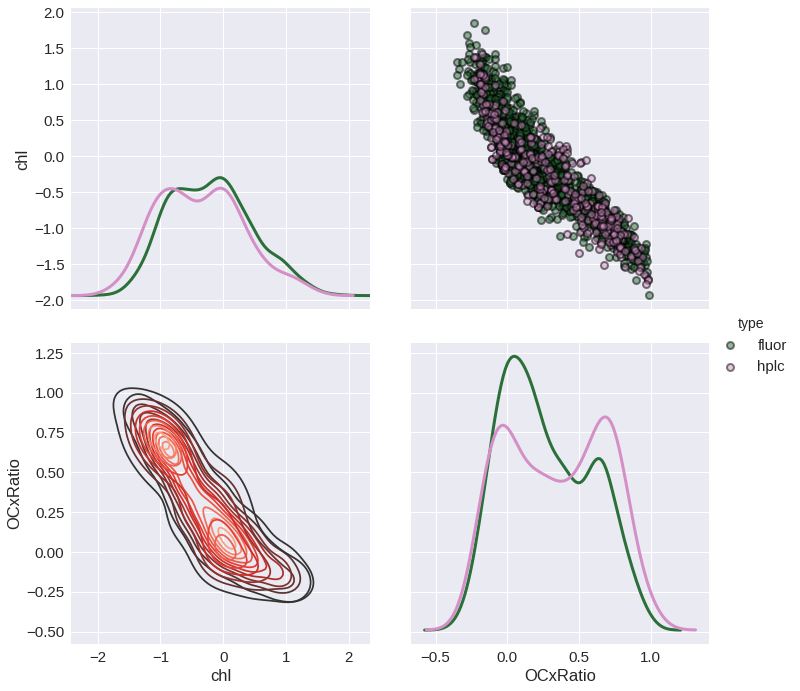

In [46]:
sb.set(font_scale=1.5)
g = sb.PairGrid(dfLogOCx, hue='type', vars=['chl','OCxRatio'], size=5,
               palette=sb.color_palette("cubehelix",2))
g = g.map_upper(pl.scatter, alpha=0.5, edgecolor='k',linewidth=2)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(sb.kdeplot,cmap="Reds_d")
g.add_legend();

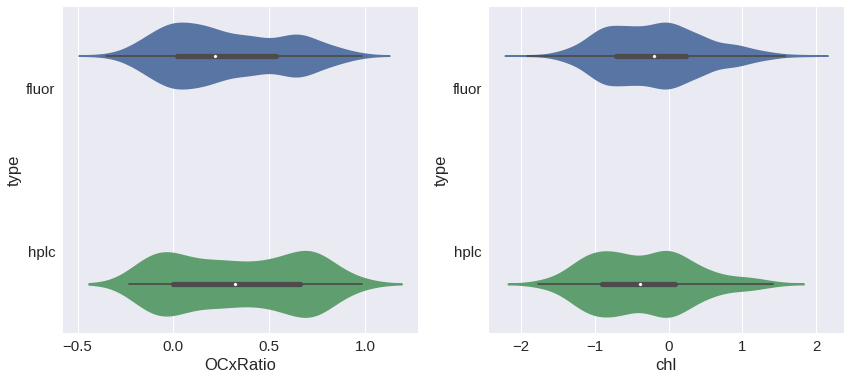

In [74]:
f,ax2 = pl.subplots(ncols=2, figsize=(14,6))
sb.violinplot(x='OCxRatio',y='type',data=dfLogOCx, hue='type', ax=ax2[0])
sb.violinplot(x='chl', y='type', data=dfLogOCx, hue='type', ax=ax2[1]);
ax2[0].legend().set_visible(False)
ax2[1].legend().set_visible(False)

In [18]:
dfSwf.type.unique()

array(['fluor', 'hplc'], dtype=object)

Pooled bayesian model:

In [56]:
logChlObs = dfLogOCx.chl.values
logOCxRatio = dfLogOCx.OCxRatio.values
OC4v6_coeffs = {'a0': 0.3272, 'a1': -2.9940, 'a2': 2.7218, 'a3': -1.2259, 'a4': -0.5683}
with pm.Model() as pooled_model:
    a0 = pm.Normal('a0', mu=OC4v6_coeffs['a0'], sd=10)
    a1 = pm.Normal('a1', mu=OC4v6_coeffs['a1'], sd=10)
    a2 = pm.Normal('a2', mu=OC4v6_coeffs['a2'], sd=10)
    a3 = pm.Normal('a3', mu=OC4v6_coeffs['a3'], sd=10)
    a4 = pm.Normal('a4', mu=OC4v6_coeffs['a4'], sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * logOCxRatio + a2 * logOCxRatio**2 + a3 *\
        logOCxRatio**3 + a4 * logOCxRatio**4
    logChlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=logChlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceOCx_pooled = pm.sample(10000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval_ to model.
100%|██████████| 10000/10000 [01:03<00:00, 157.16it/s]


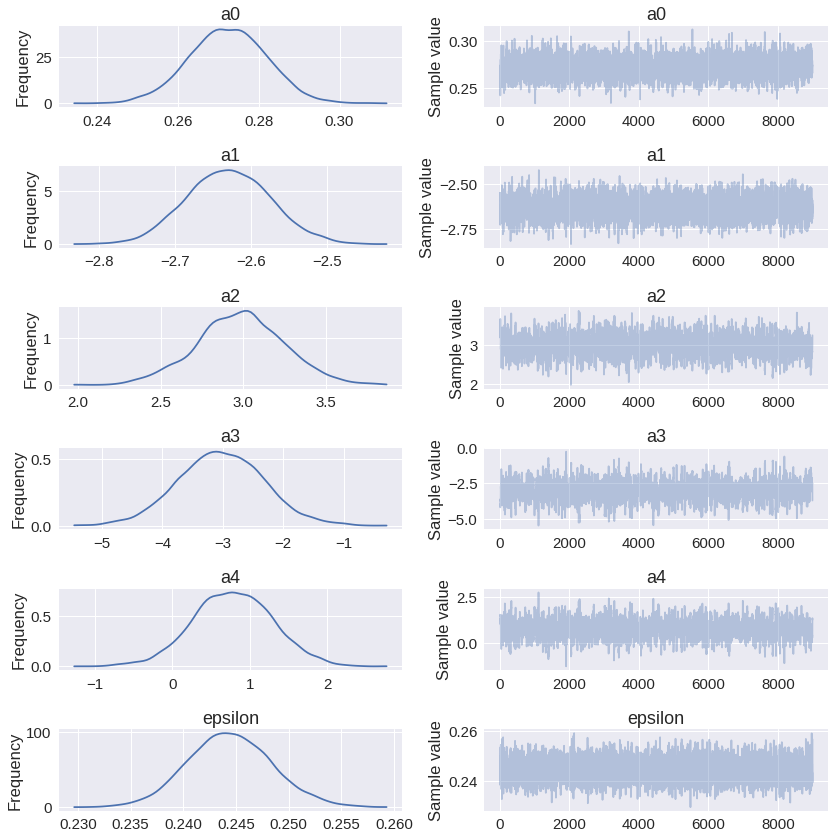

In [57]:
chainOCx_pooled = traceOCx_pooled[1000:]
varnames=['a%d' %d for d in range(5)] + ['epsilon']
#refvals = [chainOCx_pooles['a%d'] % d for d in arange(5)]
#refval = {'a%d' % d: rv for d,rv in zip(range(5), chainOCx_pooled['a%d'] )}
pm.traceplot(chainOCx_pooled,varnames=varnames, grid=True);

In [48]:
cfs = FitPoly(logOCxRatio,logChlObs)

In [68]:
{'a%d' %d:rv for d,rv in zip(range(5),cfs[::-1])}

{'a0': 0.27228861936859938,
 'a1': -2.6300188567999236,
 'a2': 2.9843631807656936,
 'a3': -3.0260868146893696,
 'a4': 0.77992631589289596}

In [67]:
OC4v6_coeffs

{'a0': 0.3272, 'a1': -2.994, 'a2': 2.7218, 'a3': -1.2259, 'a4': -0.5683}

In [61]:
refvals = [chainOCx_pooled['a%d'% d].mean() for d in range(5)]

In [55]:
# bayes means with OC4_v6 mean normal priors
refvals

[0.27252810480015494,
 -2.6288882032096033,
 2.977846923622308,
 -3.0204603062159077,
 0.77961255492740311]

In [59]:
# bayes means with 0-mean normal priors
refvals

[0.2723828704775838,
 -2.6296346511173208,
 2.983046339807371,
 -3.0278576753990398,
 0.78360428446675046]